# Style-Free Converter for Text
Conversion to a style free version of a piece of text is a crucial step for text style transfer, as outlined in the paper: 

https://aclanthology.org/2023.ijcnlp-main.9.pdf (Conversation Style Transfer using Few-Shot Learning)

### Purpose:
The ultimate goal is to create an end-to-end style transfer system that can be implemented within a chatbot. Such style transfer will allow the AI agent to communicate in a manner that is most comfortable to users.

### Script Purpose:
This script will be focused with the application and validation of Style-free text conversion

In [85]:
! pip3 install spacy
! pip install transformers torch
! python3 -m spacy download en_core_web_sm
! python3 -m spacy download en_core_web_md
! pip install spacy
! pip3 install pandas openpyxl
! pip3 install nltk
! pip install sentence-transformers
! pip install bert-score
! pip install textstat

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 14.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [145]:
import spacy
from transformers import pipeline, T5ForConditionalGeneration, T5Tokenizer
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import wordnet as wn

from bert_score import score
import textstat

from sentence_transformers import SentenceTransformer, util

from lexicalrichness import LexicalRichness

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

nlp = spacy.load("en_core_web_md")

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/cameron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/cameron/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Create English Word Frequency List

We are going to simplify the words in each sample text by words with similar contextual meaning that are more common (i.e., words with higher frequency).

This will be done using the Subtlex.US.txt corpus, which is a corpus of movies subtitles made from an original corpus of 51 million words (with movies lines randomized to prevent copyright).

The corpus is unorganized text, so we will have to create a frequency list for it to be useful. 

In [87]:
subtlex_us_path = "/Users/cameron/Documents/GitHub/Yenche_W266_Final_Proj/Subtlex US/Subtlex.US.txt"

def create_frequency_list_from_txt(file_path):
    with open(file_path, 'r', encoding='ascii', errors='ignore') as file:
        text = file.read()

    # Convert to lowercase text and split into words
    words = re.findall(r'\b\w+\b', text.lower())

    # Compute frequencies
    frequency_counter = Counter(words)

    # Convert to dictionary
    frequency_dict = dict(frequency_counter)

    return frequency_dict

frequency_dict = create_frequency_list_from_txt(subtlex_us_path)

In [88]:
# Test the look up of common words
word1 = 'the'
print(f"Frequency of '{word1}':", frequency_dict.get(word1, 0))

word2 = 'a'
print(f"Frequency of '{word2}':", frequency_dict.get(word2, 0))

word3 = 'love'
print(f"Frequency of '{word3}':", frequency_dict.get(word3, 0))

word4 = 'incredible'
print(f"Frequency of '{word4}':", frequency_dict.get(word4, 0))

Frequency of 'the': 1472785
Frequency of 'a': 1030450
Frequency of 'love': 55085
Frequency of 'incredible': 1905


#### Exploratory Style Converter

In [89]:
# Instantiate BERT embeddings
embedder = pipeline('feature-extraction', model='bert-base-uncased', framework='pt')

In [90]:
class StyleConverter:
    '''This class was used for experimentation during EDA, it may still be clunky compared to the later iteration. 
    Within you will find methods for processing the text, applying T5 commands and methods related to vocabulary replacement
    '''
    def __init__(self, frequency_dict, model_name='t5-small'):
        self.model_name = model_name
        self.tokenizer = T5Tokenizer.from_pretrained(self.model_name, model_max_length=1024)
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_name)
        self.frequency_dict = frequency_dict
        self.embedder = pipeline('feature-extraction', model='bert-base-uncased', framework='pt')
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        
    def process_text(self, text, task="summarize", max_length=100, min_length=5):
        prefix = f"{task}: " + text
        input_ids = self.tokenizer.encode(prefix, return_tensors="pt", truncation=True)
        output_ids = self.model.generate(
            input_ids, 
            max_length=max_length, 
            min_length=min_length, 
            length_penalty=1.0, 
            num_beams=2, 
            early_stopping=True
        )
        return self.tokenizer.decode(output_ids[0], skip_special_tokens=True)

    def get_word_frequency(self, word):
        return self.frequency_dict.get(word, 0)

    def get_common_synonyms(self, word, pos=None):
        synonyms = set()
        for syn in wn.synsets(word, pos=pos):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ')
                if synonym.lower() != word.lower() and self.frequency_dict.get(synonym.lower(), 0) > self.get_word_frequency(word):
                    synonyms.add(synonym)
        return list(synonyms)

    def get_most_common_synonym(self, word, context_sentence):
        synonyms = self.get_common_synonyms(word)
        if not synonyms:
            return word

        original_embedding = self.sentence_model.encode(context_sentence, convert_to_tensor=True)
        best_synonym = word
        highest_similarity = -1 # set default

        for synonym in synonyms:
            modified_sentence = context_sentence.replace(word, synonym)
            modified_embedding = self.sentence_model.encode(modified_sentence, convert_to_tensor=True)
            similarity = util.pytorch_cos_sim(original_embedding, modified_embedding).item()
            if similarity > highest_similarity:
                best_synonym = synonym
                highest_similarity = similarity

        return best_synonym

    def simplify_text(self, text, frequency_threshold=2000):
        simplified_text = []
        for sentence in nlp(text).sents:
            simplified_sentence_parts = []
            for token in sentence:
                if token.is_stop or token.is_punct:
                    simplified_sentence_parts.append(token.text)
                    continue
                
                if self.get_word_frequency(token.text.lower()) < frequency_threshold:
                    best_synonym = self.get_most_common_synonym(token.text.lower(), sentence.text)
                    simplified_sentence_parts.append(best_synonym)
                else:
                    simplified_sentence_parts.append(token.text)

            simplified_sentence = ' '.join(simplified_sentence_parts)
            simplified_text.append(simplified_sentence)

        return ' '.join(simplified_text)
    
    def convert_to_style_free(self, text, frequency_threshold=2000, iterations=2):
        processed_text = text
        for _ in range(iterations):
            summarized_text = self.process_text(processed_text, task="summarize")
            paraphrased_text = self.process_text(summarized_text, task="paraphrase")
            processed_text = self.process_text(paraphrased_text, task="simplify")
            simplified_text = self.simplify_text(processed_text, frequency_threshold=frequency_threshold)
            processed_text = simplified_text
        return processed_text

In [91]:
# Test example:
converter = StyleConverter(frequency_dict)
styled_text = "Amidst the ethereal twilight, the celestial bodies danced in harmony, their radiant hues painting the canvas of the sky with breathtaking elegance, while the gentle zephyrs whispered secrets of ancient lore." # Example complex sentence
style_free_text = converter.convert_to_style_free(styled_text)
print("\n Style-Free Text:", style_free_text)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



 Style-Free Text: rephrase : rephrase : the heavenly body dance in harmony in the heavenly fall .


### Preliminary Evaluation (Sentiment Alignment)
When determining which T5 configuration is most suitable, we will assess based on preliminary metrics, including BERTScore and Flesch Reading-Ease Score:
- **BERTScore:** will be used to assess how well meaning is transferred as the text is converted into a style-free form.

- **Flesch Reading-Ease:** will be used to assess text complexity and thus readability. 

***Note:*** Other style evaluation metrics will be assessed within a later section of the notebook.

In [92]:
class TextEvaluator:
    def __init__(self, lang="en"):
        self.lang = lang

    def evaluate(self, original_text, transformed_text):
        # Calculate BERTScore
        P, R, F1 = score([transformed_text], [original_text], lang=self.lang)
        bert_precision = P.mean().item()
        bert_recall = R.mean().item()
        bert_f1 = F1.mean().item()

        # Calculate Flesch Reading Score
        original_flesch_score = textstat.flesch_reading_ease(original_text)
        transformed_flesch_score = textstat.flesch_reading_ease(transformed_text)

        print(f"Original Text Flesch Reading Ease Score: {original_flesch_score:.2f}")
        print(f"Transformed Text Flesch Reading Ease Score: {transformed_flesch_score:.2f}")
        print(f"BERTScore Precision: {bert_precision:.4f}")
        print(f"BERTScore Recall: {bert_recall:.4f}")
        print(f"BERTScore F1: {bert_f1:.4f}")

        return {
            "original_flesch_score": original_flesch_score,
            "transformed_flesch_score": transformed_flesch_score,
            "bert_precision": bert_precision,
            "bert_recall": bert_recall,
            "bert_f1": bert_f1
        }

In [93]:
# Evaluate on example
evaluator = TextEvaluator()

original_text = styled_text
transformed_text = style_free_text
evaluation_results = evaluator.evaluate(original_text, transformed_text)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original Text Flesch Reading Ease Score: 40.01
Transformed Text Flesch Reading Ease Score: 50.84
BERTScore Precision: 0.8468
BERTScore Recall: 0.8376
BERTScore F1: 0.8422


### Small Model
Original Text Flesch Reading-Ease Score: 40.01
Transformed Text Flesch Reading-Ease Score: 50.84
BERTScore Precision: 0.8468
BERTScore Recall: 0.8376
BERTScore F1: 0.8422

### Base Model
Original Text Flesch Reading-Ease Score: 40.01
Transformed Text Flesch Reading-Ease Score: 53.88
BERTScore Precision: 0.9402
BERTScore Recall: 0.8717
BERTScore F1: 0.9047

### Large Model
Original Text Flesch Reading-Ease Score: 40.01
Transformed Text Flesch Reading-Ease Score: 31.89
BERTScore Precision: 0.9533
BERTScore Recall: 0.8929
BERTScore F1: 0.9221

This is just an initial exploration of the a viable model, we will compare different approaches in greater detail later in the notebook

 ### Style Evaluation Metrics
 We will now evaluate the style-free conversion model based on custom style-evaluation metrics.
 - We'll start with lexical richness, which will serve as a proxy for style.

In [94]:
def calculate_lexical_richness(text):
    lex = LexicalRichness(text)
    ttr = lex.ttr
    mtld = lex.mtld(threshold=0.72)
    return ttr, mtld

In [95]:
# Examine and compare type token ratio (i.e., the total number of unique words)
print("Styled Text Type Token Ratio", calculate_lexical_richness(styled_text)[0])
print("Style Free Text Type Token Ratio", calculate_lexical_richness(style_free_text)[0])

Styled Text Type Token Ratio 0.8387096774193549
Style Free Text Type Token Ratio 0.6666666666666666 



After transforming the text to be style-free, the TTR decreases to 0.66, suggesting a reduction in vocabulary diversity. This could indicate that the transformation process standardizes or simplifies word choice to reduce stylistic variations.

In [96]:
# Examine and compare lexical diversity
print("Styled Text Lexical Diversity", calculate_lexical_richness(styled_text)[1])
print("Style Free Lexical Diversity", calculate_lexical_richness(style_free_text)[1])

Styled Text Lexical Diversity 53.81600000000002
Style Free Lexical Diversity 6.0


The original styled text has an MTLD of 53.816, which drops significantly to 6.0 in the style-free text. This sharp decrease further suggests that the transformation process simplifies the text.

### Apply & Evaluate Style Free Converter on Twitter Customer Service Interactions
- To simulate the type of text that could be found by a customer chatbot, we will use customer support text from Twitter.
    - The dataset in question can be found at the following link: https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter#
    

In [97]:
df = pd.read_csv('./Twitter_Support/twcs/twcs.csv')
print(df.columns)

tweets = df['text'].tolist()

num_tweets = len(df)
print(f"Total number of tweets in the dataset: {num_tweets}")

def preprocess_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\S+', '', tweet)  # Remove mentions / user handles
    tweet = re.sub(r'#\S+', '', tweet)  # Remove hashtags
    return tweet

tweets = [preprocess_tweet(tweet) for tweet in tweets]

# Randomly sample 1000 tweets
subset_df = df.sample(n=1000, random_state=42)

Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id'],
      dtype='object')
Total number of tweets in the dataset: 2811774


In [98]:
tweets = subset_df['text']

# Split the data - 80% for test and 20% for validation
X_test, X_val = train_test_split(tweets, test_size=0.2, random_state=42)

print(f"Number of tweets in the test set: {len(X_test)}")
print(f"Number of tweets in the validation set: {len(X_val)}")

Number of tweets in the test set: 800
Number of tweets in the validation set: 200


In [99]:
def process_tweets_in_batches(tweets, converter_type, batch_size=100):
    '''Processes tweets in batches, allows for converter instance to be changed (for future testing)'''
    style_free_tweets = []
    for i in range(0, len(tweets), batch_size):
        batch = tweets[i:i + batch_size]
        for tweet in batch:
            # Convert tweet to style-free text
            style_free_tweet = converter_type.convert_to_style_free(tweet)
            style_free_tweets.append(style_free_tweet)
    return style_free_tweets

style_free_tweets_val = process_tweets_in_batches(X_val.tolist(), converter, batch_size=100)

### Create Evaluation Class for Efficient Metric Scoring

In [106]:
class TweetMetricsChange:
    '''This class computes metric changes between original and transformed text, when applicable'''
    def __init__(self):
        # Instantiate lists for calculating changes
        self.original_readability_scores = []
        self.transformed_readability_scores = []
        self.original_lexical_ttr_scores = []
        self.transformed_lexical_ttr_scores = []
        self.original_lexical_mtld_scores = []
        self.transformed_lexical_mtld_scores = []

        # Instantiate lists for BERT scores 
        self.bert_precision_scores = []
        self.bert_recall_scores = []
        self.bert_f1_scores = []

    def compute_readability_and_lexical_scores(self, original_text, transformed_text):
        if transformed_text.strip() and any(char.isalpha() for char in transformed_text):  # Ensure text is valid
            self.original_readability_scores.append(textstat.flesch_reading_ease(original_text))
            self.transformed_readability_scores.append(textstat.flesch_reading_ease(transformed_text))

            # Compute and store lexical richness scores for original and transformed texts
            original_lex = LexicalRichness(original_text)
            transformed_lex = LexicalRichness(transformed_text)
            self.original_lexical_ttr_scores.append(original_lex.ttr)
            self.transformed_lexical_ttr_scores.append(transformed_lex.ttr)
            self.original_lexical_mtld_scores.append(original_lex.mtld(threshold=0.72))
            self.transformed_lexical_mtld_scores.append(transformed_lex.mtld(threshold=0.72))
        else:
            # Append default values for invalid texts
            self.original_readability_scores.append(0)
            self.transformed_readability_scores.append(0)
            self.original_lexical_ttr_scores.append(0)
            self.transformed_lexical_ttr_scores.append(0)
            self.original_lexical_mtld_scores.append(0)
            self.transformed_lexical_mtld_scores.append(0)

    def compute_bert_scores(self, original_text, transformed_text):
        # Compute BERTScore metrics
        P, R, F1 = score([transformed_text], [original_text], lang="en")
        self.bert_precision_scores.append(P.mean().item())
        self.bert_recall_scores.append(R.mean().item())
        self.bert_f1_scores.append(F1.mean().item())

    def evaluate_tweet(self, original_text, transformed_text):
        # Evaluate readability and lexical richness for both original and transformed texts
        self.compute_readability_and_lexical_scores(original_text, transformed_text)
        # Evaluate BERT scores comparing original and transformed texts
        self.compute_bert_scores(original_text, transformed_text)

    def average_metric_changes(self):
        # Filter entries with non-negative transformed readability scores
        valid_readability_changes = [t - o for o, t in zip(self.original_readability_scores, self.transformed_readability_scores) if t >= 0]

        # Calculate average changes in metrics
        avg_readability_change = sum(valid_readability_changes) / len(valid_readability_changes) if valid_readability_changes else 0
        avg_ttr_change = sum(t - o for o, t in zip(self.original_lexical_ttr_scores, self.transformed_lexical_ttr_scores)) / len(self.original_lexical_ttr_scores) if self.original_lexical_ttr_scores else 0
        avg_mtld_change = sum(t - o for o, t in zip(self.original_lexical_mtld_scores, self.transformed_lexical_mtld_scores)) / len(self.original_lexical_mtld_scores) if self.original_lexical_mtld_scores else 0

        # Calculate average scores for BERT metrics
        avg_bert_precision = sum(self.bert_precision_scores) / len(self.bert_precision_scores) if self.bert_precision_scores else 0
        avg_bert_recall = sum(self.bert_recall_scores) / len(self.bert_recall_scores) if self.bert_recall_scores else 0
        avg_bert_f1 = sum(self.bert_f1_scores) / len(self.bert_f1_scores) if self.bert_f1_scores else 0

        avg_changes = {
            "avg_readability_change": avg_readability_change,
            "avg_ttr_change": avg_ttr_change,
            "avg_mtld_change": avg_mtld_change,
            "avg_bert_precision": avg_bert_precision,
            "avg_bert_recall": avg_bert_recall,
            "avg_bert_f1": avg_bert_f1,
        }
        return avg_changes


In [154]:
metrics_change_evaluator = TweetMetricsChange()
for original, transformed in zip(X_val, style_free_tweets_val):
    metrics_change_evaluator.evaluate_tweet(original, transformed)

avg_metric_changes = metrics_change_evaluator.average_metric_changes()
print(f"Average Metric Changes:\n{avg_metric_changes}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average Metric Changes:
{'avg_readability_change': -13.964050632911388, 'avg_ttr_change': -0.09874631362911339, 'avg_mtld_change': -44.36669991726706, 'avg_bert_precision': 0.823970393538475, 'avg_bert_recall': 0.8322635045647622, 'avg_bert_f1': 0.8268995586037636}


### Experiment with different model structures
- First we will experiment with the most basic t5 commands "summarize" and "simplify" and then determine which t5 model performs the best (T5-small, T5-base, and T5-large)
- Then we will experiment with adding "summarize" and "paraphrase" commands in addition to "simplify" to determine which performs best
- Then we will experiment with vocabulary simplification. 

**The best performing model will be taken as the model to be applied to the Test Dataset**

### Evaluate Simple T5 Structure

In [108]:
class StyleConverterBasic:
    def __init__(self, model_name):
        self.model_name = model_name
        self.tokenizer = T5Tokenizer.from_pretrained(self.model_name, model_max_length=1024)
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_name)

    def process_text(self, text, task="simplify", max_length=100, min_length=5):
        prefix = f"{task}: " + text
        input_ids = self.tokenizer.encode(prefix, return_tensors="pt", truncation=True)
        output_ids = self.model.generate(input_ids, max_length=max_length, min_length=min_length, length_penalty=1.0, num_beams=2, early_stopping=True)
        return self.tokenizer.decode(output_ids[0], skip_special_tokens=True)

    def convert_to_style_free(self, text):
        summarized_text = self.process_text(text, task="summarize")
        simplified_text = self.process_text(summarized_text, task="simplify")
        return simplified_text

In [109]:
converter_small = StyleConverterBasic(model_name='t5-small')
converter_base = StyleConverterBasic(model_name='t5-base')
converter_large = StyleConverterBasic(model_name='t5-large')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [112]:
style_free_tweets_val_basic_small = process_tweets_in_batches(X_val.tolist(),converter_small, batch_size=100)
style_free_tweets_val_basic_base = process_tweets_in_batches(X_val.tolist(),converter_base, batch_size=100)
style_free_tweets_val_basic_large = process_tweets_in_batches(X_val.tolist(),converter_large, batch_size=100)

In [114]:
# Evaluate T5-Small Model with basic structure
for original, transformed in zip(X_val, style_free_tweets_val_basic_small):
    metrics_change_evaluator.evaluate_tweet(original, transformed)

avg_metric_changes = metrics_change_evaluator.average_metric_changes()
print(f"Average Metric Changes T5-Small Model, Basic Structure:\n{avg_metric_changes}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average Metric Changes T5-Small Model, Basic Structure:
{'avg_readability_change': -10.030804597701147, 'avg_ttr_change': -0.0713065963513859, 'avg_mtld_change': -36.66010817888615, 'avg_bert_precision': 0.8790649938583374, 'avg_bert_recall': 0.8700824783742428, 'avg_bert_f1': 0.8735101142525673}


In [115]:
# Evaluate T5-Base Model with basic structure
metrics_change_evaluator = TweetMetricsChange()

for original, transformed in zip(X_val, style_free_tweets_val_basic_base):
    metrics_change_evaluator.evaluate_tweet(original, transformed)

avg_metric_changes = metrics_change_evaluator.average_metric_changes()
print(f"Average Metric Changes T5-Base Model, Basic Structure:\n{avg_metric_changes}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average Metric Changes T5-Base Model, Basic Structure:
{'avg_readability_change': -0.029417989417989617, 'avg_ttr_change': -0.10529385222066268, 'avg_mtld_change': -35.026820090777925, 'avg_bert_precision': 0.9328798997402191, 'avg_bert_recall': 0.8957895848155022, 'avg_bert_f1': 0.9132253560423851}


In [116]:
# Evaluate T5-Large Model with basic structure
for original, transformed in zip(X_val, style_free_tweets_val_basic_large):
    metrics_change_evaluator.evaluate_tweet(original, transformed)

avg_metric_changes = metrics_change_evaluator.average_metric_changes()
print(f"Average Metric Changes, T5-Large Model, Basic Structure:\n{avg_metric_changes}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average Metric Changes, T5-Large Model, Basic Structure:
{'avg_readability_change': -1.5608157894736843, 'avg_ttr_change': -0.27948375803405, 'avg_mtld_change': -35.65011212624195, 'avg_bert_precision': 0.8874175934493542, 'avg_bert_recall': 0.8747204551100731, 'avg_bert_f1': 0.8801745428144931}


The T5-Base model seems to strike a better balance between readability improvement and semantic content preservation, therefore we will continue forward with this model. 

### Evaluate T5 with additional processing

#### Summarize, Paraphrase, Simplify

In [117]:
class StyleConverterIntermediate_SPS:
    def __init__(self, model_name='t5-base'):
        self.model_name = model_name
        self.tokenizer = T5Tokenizer.from_pretrained(self.model_name, model_max_length=1024)
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_name)

    def process_text(self, text, task="simplify", max_length=100, min_length=5):
        prefix = f"{task}: " + text
        input_ids = self.tokenizer.encode(prefix, return_tensors="pt", truncation=True)
        output_ids = self.model.generate(input_ids, max_length=max_length, min_length=min_length, length_penalty=1.0, num_beams=2, early_stopping=True)
        return self.tokenizer.decode(output_ids[0], skip_special_tokens=True)

    def convert_to_style_free(self, text):
        summarized_text = self.process_text(text, task="summarize")
        paraphrased_text = self.process_text(summarized_text, task="paraphrase")
        simplified_text = self.process_text(paraphrased_text, task="simplify")
        return simplified_text

In [118]:
converter_intermediate_SPS = StyleConverterIntermediate_SPS()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [119]:
style_free_tweets_val_intermediate_SPS = process_tweets_in_batches(X_val.tolist(),converter_intermediate_SPS, batch_size=100)

In [120]:
# Evaluate T5-Base Model with Intermediate structure SPS
for original, transformed in zip(X_val, style_free_tweets_val_intermediate_SPS):
    metrics_change_evaluator.evaluate_tweet(original, transformed)

avg_metric_changes = metrics_change_evaluator.average_metric_changes()
print(f"Average Metric Changes T5-Base Model, Intermediate Structure SPS:\n{avg_metric_changes}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average Metric Changes T5-Base Model, Intermediate Structure SPS:
{'avg_readability_change': 4.4047535211267625, 'avg_ttr_change': -0.3577231898188374, 'avg_mtld_change': -38.86621603577511, 'avg_bert_precision': 0.8595101291934649, 'avg_bert_recall': 0.8524130374193192, 'avg_bert_f1': 0.8549515106280645}


#### Paraphrase, Simplify

In [121]:
class StyleConverterIntermediate_PS:
    def __init__(self, model_name='t5-base'):
        self.model_name = model_name
        self.tokenizer = T5Tokenizer.from_pretrained(self.model_name, model_max_length=1024)
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_name)

    def process_text(self, text, task="simplify", max_length=100, min_length=5):
        prefix = f"{task}: " + text
        input_ids = self.tokenizer.encode(prefix, return_tensors="pt", truncation=True)
        output_ids = self.model.generate(input_ids, max_length=max_length, min_length=min_length, length_penalty=1.0, num_beams=2, early_stopping=True)
        return self.tokenizer.decode(output_ids[0], skip_special_tokens=True)

    def convert_to_style_free(self, text):
        paraphrased_text = self.process_text(text, task="paraphrase")
        simplified_text = self.process_text(paraphrased_text, task="simplify")
        return simplified_text

In [122]:
converter_intermediate_PS = StyleConverterIntermediate_PS()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [123]:
style_free_tweets_val_intermediate_PS = process_tweets_in_batches(X_val.tolist(),converter_intermediate_PS, batch_size=100)

In [124]:
# Evaluate T5-Base Model with Intermediate structure PS
for original, transformed in zip(X_val, style_free_tweets_val_intermediate_PS):
    metrics_change_evaluator.evaluate_tweet(original, transformed)

avg_metric_changes = metrics_change_evaluator.average_metric_changes()
print(f"Average Metric Changes T5-Base Model, Intermediate Structure PS:\n{avg_metric_changes}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average Metric Changes T5-Base Model, Intermediate Structure PS:
{'avg_readability_change': 8.9585298013245, 'avg_ttr_change': -0.42515382620541187, 'avg_mtld_change': -41.636357656619495, 'avg_bert_precision': 0.8397093136608601, 'avg_bert_recall': 0.8381064849346876, 'avg_bert_f1': 0.8378514923155308}


#### Summarize, Paraphrase

In [125]:
class StyleConverterIntermediate_SP:
    def __init__(self, model_name='t5-base'):
        self.model_name = model_name
        self.tokenizer = T5Tokenizer.from_pretrained(self.model_name, model_max_length=1024)
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_name)

    def process_text(self, text, task="simplify", max_length=100, min_length=5):
        prefix = f"{task}: " + text
        input_ids = self.tokenizer.encode(prefix, return_tensors="pt", truncation=True)
        output_ids = self.model.generate(input_ids, max_length=max_length, min_length=min_length, length_penalty=1.0, num_beams=2, early_stopping=True)
        return self.tokenizer.decode(output_ids[0], skip_special_tokens=True)

    def convert_to_style_free(self, text):
        summarized_text = self.process_text(text, task="summarize")
        paraphrased_text = self.process_text(summarized_text, task="paraphrase")
        return paraphrased_text

In [126]:
converter_intermediate_SP = StyleConverterIntermediate_SP()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [127]:
style_free_tweets_val_intermediate_SP = process_tweets_in_batches(X_val.tolist(),converter_intermediate_SP, batch_size=100)

In [128]:
# Evaluate T5-Base Model with Intermediate structure SP

for original, transformed in zip(X_val, style_free_tweets_val_intermediate_SP):
    metrics_change_evaluator.evaluate_tweet(original, transformed)

avg_metric_changes = metrics_change_evaluator.average_metric_changes()
print(f"Average Metric Changes T5-Base Model, Intermediate Structure SP:\n{avg_metric_changes}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average Metric Changes T5-Base Model, Intermediate Structure SP:
{'avg_readability_change': 12.473150105708255, 'avg_ttr_change': -0.3390558192637832, 'avg_mtld_change': -43.25926833785541, 'avg_bert_precision': 0.843733990073204, 'avg_bert_recall': 0.8325894238948822, 'avg_bert_f1': 0.8370325554609299}


Based on these results, the SP structure outperforms the others, therefore we will proceed with this structure.

### Evaluate with T5 + Vocabulary Replacement

In [129]:
class StyleConverter_Advanced:
    def __init__(self, frequency_dict, model_name='t5-base'):
        self.model_name = model_name
        self.tokenizer = T5Tokenizer.from_pretrained(self.model_name, model_max_length=1024)
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_name)
        self.frequency_dict = frequency_dict
        self.embedder = pipeline('feature-extraction', model='bert-base-uncased', framework='pt')
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        
    def process_text(self, text, task="summarize", max_length=100, min_length=5):
        prefix = f"{task}: " + text
        input_ids = self.tokenizer.encode(prefix, return_tensors="pt", truncation=True)
        output_ids = self.model.generate(
            input_ids, 
            max_length=max_length, 
            min_length=min_length, 
            length_penalty=1.0, 
            num_beams=2, 
            early_stopping=True
        )
        return self.tokenizer.decode(output_ids[0], skip_special_tokens=True)

    def get_word_frequency(self, word):
        return self.frequency_dict.get(word, 0)

    def get_common_synonyms(self, word, pos=None):
        synonyms = set()
        for syn in wn.synsets(word, pos=pos):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ')
                if synonym.lower() != word.lower() and self.frequency_dict.get(synonym.lower(), 0) > self.get_word_frequency(word):
                    synonyms.add(synonym)
        return list(synonyms)

    def get_most_common_synonym(self, word, context_sentence):
        synonyms = self.get_common_synonyms(word)
        if not synonyms:
            return word

        original_embedding = self.sentence_model.encode(context_sentence, convert_to_tensor=True)
        best_synonym = word
        highest_similarity = -1
        for synonym in synonyms:
            modified_sentence = context_sentence.replace(word, synonym)
            modified_embedding = self.sentence_model.encode(modified_sentence, convert_to_tensor=True)
            similarity = util.pytorch_cos_sim(original_embedding, modified_embedding).item()
            if similarity > highest_similarity:
                best_synonym = synonym
                highest_similarity = similarity

        return best_synonym

    def simplify_text(self, text, frequency_threshold=2000): # experimented with 10000, 5000, and 2000
        simplified_text = []
        for sentence in nlp(text).sents:
            simplified_sentence_parts = []
            for token in sentence:
                if token.is_stop or token.is_punct:
                    simplified_sentence_parts.append(token.text)
                    continue
                
                if self.get_word_frequency(token.text.lower()) < frequency_threshold:
                    best_synonym = self.get_most_common_synonym(token.text.lower(), sentence.text)
                    simplified_sentence_parts.append(best_synonym)
                else:
                    simplified_sentence_parts.append(token.text)

            simplified_sentence = ' '.join(simplified_sentence_parts)
            simplified_text.append(simplified_sentence)

        return ' '.join(simplified_text)
    
    def convert_to_style_free(self, text, frequency_threshold=2000, iterations=2): # experimented with 10000, 5000, and 2000, # tested 1 and 2 passes 
        for _ in range(iterations):
            summarized_text = self.process_text(text, task="summarize")
            paraphrased_text = self.process_text(summarized_text, task="paraphrase")
            simplified_text = self.simplify_text(paraphrased_text, frequency_threshold=frequency_threshold)
        return simplified_text

In [ ]:
Converter_Advanced = StyleConverter_Advanced(frequency_dict)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
style_free_tweets_val_advanced = process_tweets_in_batches(X_val.tolist(),Converter_Advanced, batch_size=100)

In [130]:
# Evaluate T5-Base Model with Advanced Structure (i.e. word replacement)
for original, transformed in zip(X_val, style_free_tweets_val_advanced):
    metrics_change_evaluator.evaluate_tweet(original, transformed)

avg_metric_changes = metrics_change_evaluator.average_metric_changes()
print(f"Average Metric Changes T5-Base Model, Advanced Structure:\n{avg_metric_changes}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average Metric Changes T5-Base Model, Advanced Structure:
{'avg_readability_change': 14.587805092186136, 'avg_ttr_change': -0.28173681244384946, 'avg_mtld_change': -44.345110752797, 'avg_bert_precision': 0.8419309673209985, 'avg_bert_recall': 0.827787612726291, 'avg_bert_f1': 0.833717819750309}


#### Now Evaluate on the Test Dataset

In [131]:
style_free_tweets_test_advanced = process_tweets_in_batches(X_test.tolist(),Converter_Advanced, batch_size=100)

In [132]:
# Evaluate T5-Base Model with Advanced Structure (i.e. word replacement) on Test Data
for original, transformed in zip(X_test, style_free_tweets_test_advanced):
    metrics_change_evaluator.evaluate_tweet(original, transformed)

avg_metric_changes = metrics_change_evaluator.average_metric_changes()
print(f"Average Metric Changes T5-Base Model, Advanced Structure:\n{avg_metric_changes}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average Metric Changes T5-Base Model, Advanced Structure:
{'avg_readability_change': 17.158554790894694, 'avg_ttr_change': -0.16682001243132258, 'avg_mtld_change': -46.73678626809012, 'avg_bert_precision': 0.8441448625922203, 'avg_bert_recall': 0.8224699560999871, 'avg_bert_f1': 0.8321500406563282}


### Plot Generation

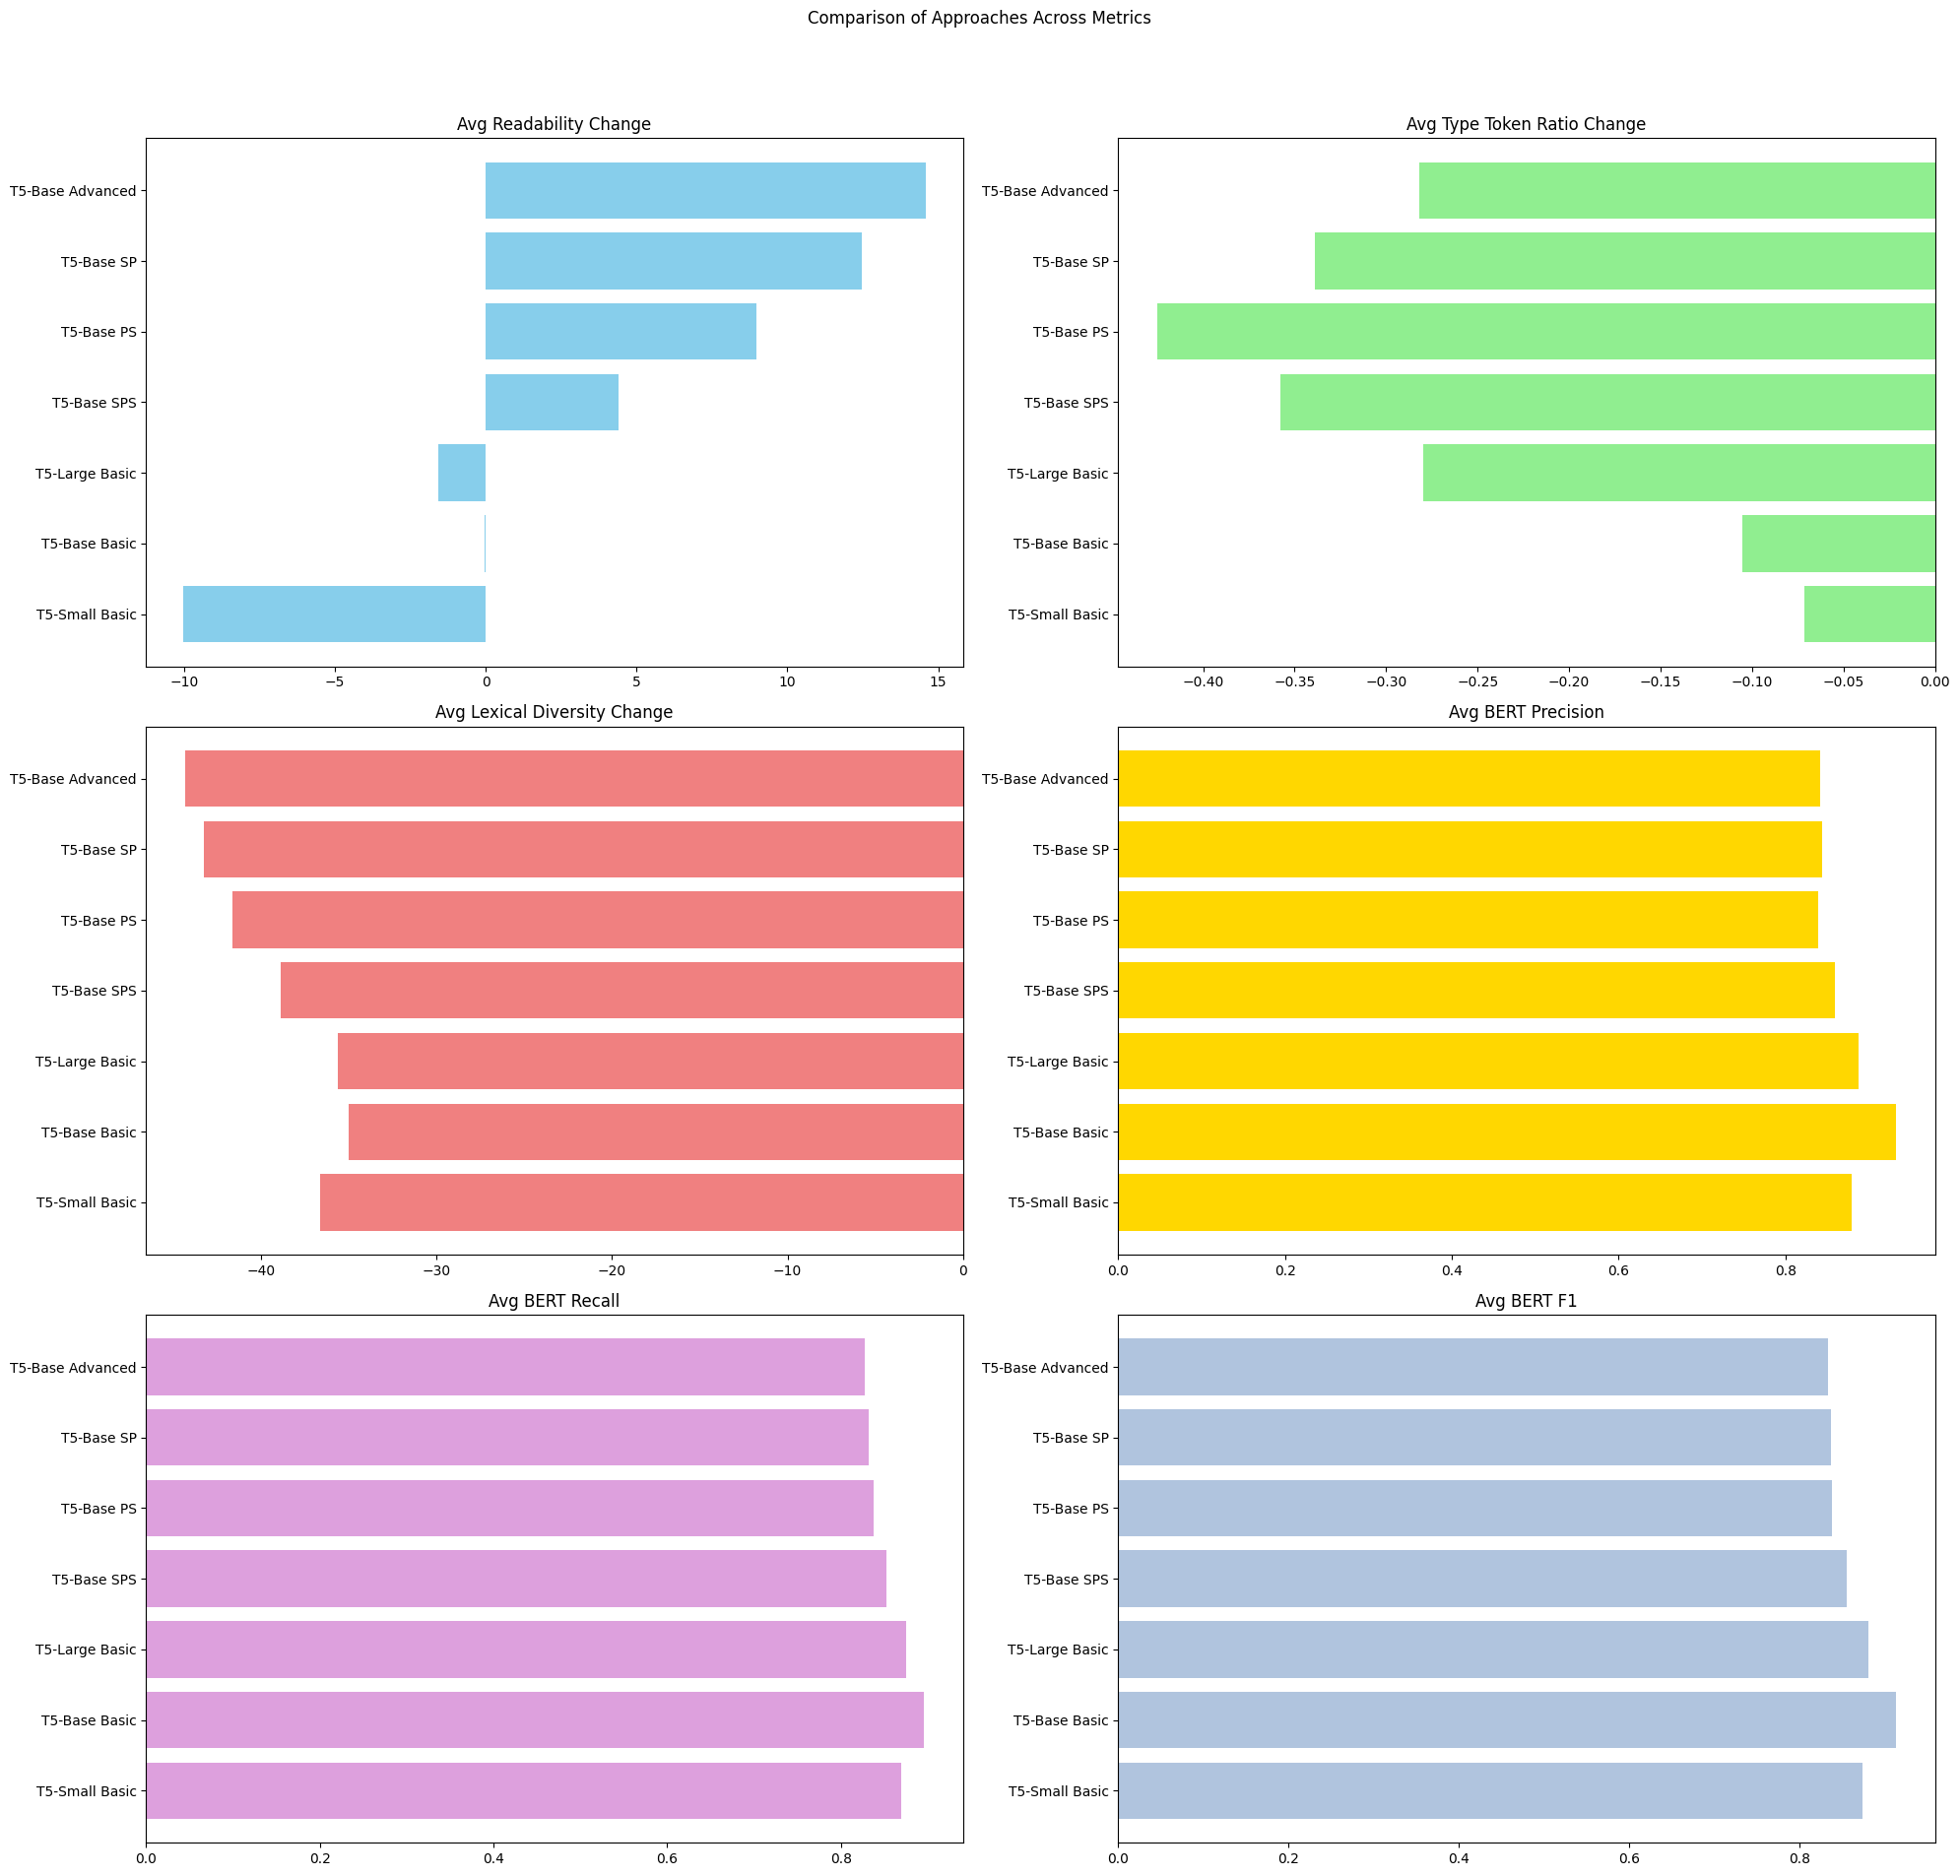

In [134]:
# I had to manually type the data, since I forgot to save the variables separately (and it took hours to run).
models = ['T5-Small Basic', 'T5-Base Basic', 'T5-Large Basic', 'T5-Base SPS', 'T5-Base PS', 'T5-Base SP', 'T5-Base Advanced']
avg_readability_change = [-10.030804597701147, -0.029417989417989617, -1.5608157894736843, 4.4047535211267625, 8.9585298013245, 12.473150105708255, 14.587805092186136]
avg_ttr_change = [-0.0713065963513859, -0.10529385222066268, -0.27948375803405, -0.3577231898188374, -0.42515382620541187, -0.3390558192637832, -0.28173681244384946]
avg_mtld_change = [-36.66010817888615, -35.026820090777925, -35.65011212624195, -38.86621603577511, -41.636357656619495, -43.25926833785541, -44.345110752797]
avg_bert_precision = [0.8790649938583374, 0.9328798997402191, 0.8874175934493542, 0.8595101291934649, 0.8397093136608601, 0.843733990073204, 0.8419309673209985]
avg_bert_recall = [0.8700824783742428, 0.8957895848155022, 0.8747204551100731, 0.8524130374193192, 0.8381064849346876, 0.8325894238948822, 0.827787612726291]
avg_bert_f1 = [0.8735101142525673, 0.9132253560423851, 0.8801745428144931, 0.8549515106280645, 0.8378514923155308, 0.8370325554609299, 0.833717819750309]

fig, axs = plt.subplots(3, 2, figsize=(20, 20))
fig.suptitle('Comparison of Approaches Across Metrics')

# Plot
axs[0, 0].barh(models, avg_readability_change, color='skyblue')
axs[0, 0].set_title('Avg Readability Change')

axs[0, 1].barh(models, avg_ttr_change, color='lightgreen')
axs[0, 1].set_title('Avg Type Token Ratio Change')
axs[1, 0].barh(models, avg_mtld_change, color='lightcoral')
axs[1, 0].set_title('Avg Lexical Diversity Change')

axs[1, 1].barh(models, avg_bert_precision, color='gold')
axs[1, 1].set_title('Avg BERT Precision')

axs[2, 0].barh(models, avg_bert_recall, color='plum')
axs[2, 0].set_title('Avg BERT Recall')

axs[2, 1].barh(models, avg_bert_f1, color='lightsteelblue')
axs[2, 1].set_title('Avg BERT F1')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [142]:
class TweetMetricsSimple:
    '''modified version of earlier class (rewritten so I didnt have to run earlier cells) that stores metrics in vectors rather than finding their averages'''
    def __init__(self):
        # Initialize lists for calculating changes
        self.original_readability_scores = []
        self.transformed_readability_scores = []
        self.original_lexical_ttr_scores = []
        self.transformed_lexical_ttr_scores = []
        self.original_lexical_mtld_scores = []
        self.transformed_lexical_mtld_scores = []

        # Initialize lists to store BERT scores
        self.bert_precision_scores = []
        self.bert_recall_scores = []
        self.bert_f1_scores = []

    def compute_readability_and_lexical_scores(self, original_text, transformed_text):
        if transformed_text.strip() and any(char.isalpha() for char in transformed_text):  # Ensure text is valid
            self.original_readability_scores.append(textstat.flesch_reading_ease(original_text))
            self.transformed_readability_scores.append(textstat.flesch_reading_ease(transformed_text))

            # Compute and store lexical richness scores for original and transformed texts
            original_lex = LexicalRichness(original_text)
            transformed_lex = LexicalRichness(transformed_text)
            self.original_lexical_ttr_scores.append(original_lex.ttr)
            self.transformed_lexical_ttr_scores.append(transformed_lex.ttr)
            self.original_lexical_mtld_scores.append(original_lex.mtld(threshold=0.72))
            self.transformed_lexical_mtld_scores.append(transformed_lex.mtld(threshold=0.72))
        else:
            self.original_readability_scores.append(0)
            self.transformed_readability_scores.append(0)
            self.original_lexical_ttr_scores.append(0)
            self.transformed_lexical_ttr_scores.append(0)
            self.original_lexical_mtld_scores.append(0)
            self.transformed_lexical_mtld_scores.append(0)

    def compute_bert_scores(self, original_text, transformed_text):
        # Compute BERTScore metrics (now not taking the average)
        P, R, F1 = score([transformed_text], [original_text], lang="en")
        self.bert_precision_scores.append(P)
        self.bert_recall_scores.append(R)
        self.bert_f1_scores.append(F1)

    def evaluate_tweet(self, original_text, transformed_text):
        self.compute_readability_and_lexical_scores(original_text, transformed_text)
        self.compute_bert_scores(original_text, transformed_text)

    def get_scores_vectors(self):
            return (self.original_readability_scores, self.transformed_readability_scores, 
                    self.original_lexical_ttr_scores, self.transformed_lexical_ttr_scores, 
                    self.original_lexical_mtld_scores, self.transformed_lexical_mtld_scores, 
                    self.bert_precision_scores, self.bert_recall_scores, 
                    self.bert_f1_scores)


In [143]:
vector_extractor = TweetMetricsSimple()

for original, transformed in zip(X_test, style_free_tweets_test_advanced):
    vector_extractor.evaluate_tweet(original, transformed)

original_readability_scores, transformed_readability_scores, original_ttr_scores, transformed_ttr_scores, original_mtld_scores, transformed_mtld_scores, bert_precision_scores, bert_recall_scores, bert_f1_scores = vector_extractor.get_scores_vectors()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

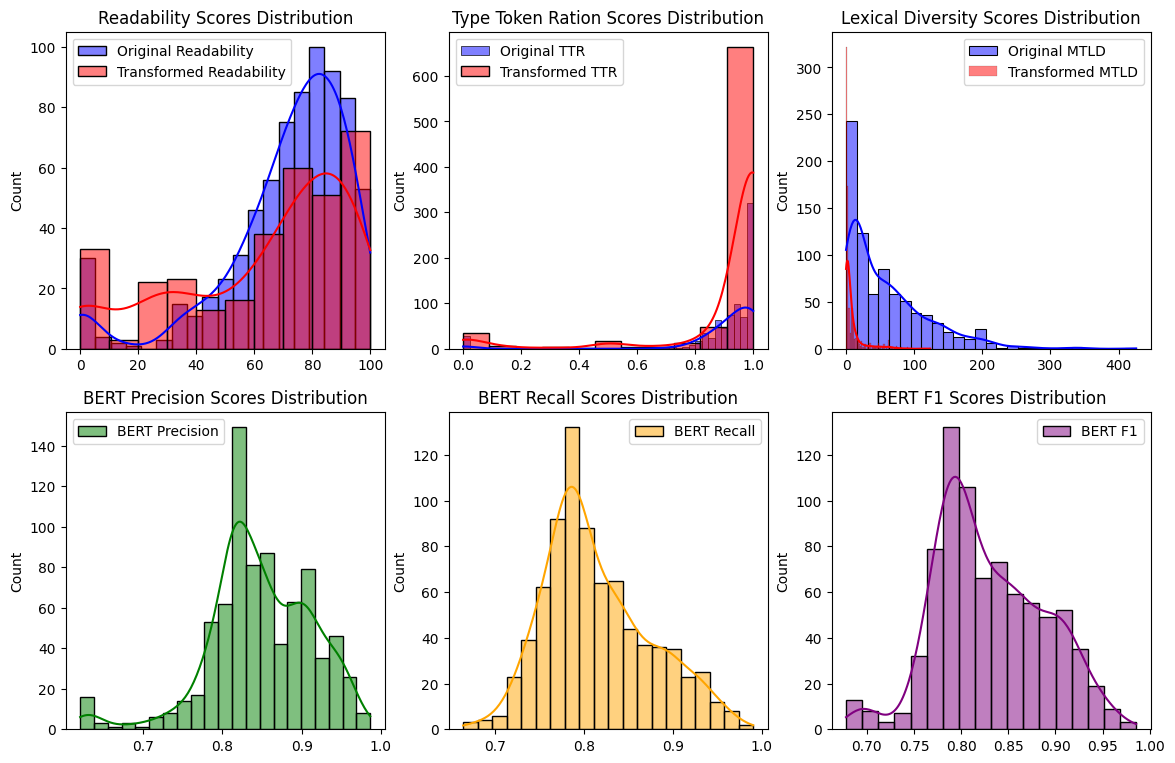

In [153]:
plt.figure(figsize=(14, 14))

# Plot of readability scores
filtered_original_readability_scores = [score for score in original_readability_scores if 0 <= score <= 100] # filter out unrealistic readbility scores (supposed to be between 0 and 100)
filtered_transformed_readability_scores = [score for score in transformed_readability_scores if 0 <= score <= 100]

plt.subplot(3, 3, 1)
sns.histplot(filtered_original_readability_scores, color="blue", label="Original Readability", kde=True)
sns.histplot(filtered_transformed_readability_scores, color="red", label="Transformed Readability", kde=True)
plt.legend()
plt.title("Readability Scores Distribution")

# Plot of TTR scores
plt.subplot(3, 3, 2)
sns.histplot(original_ttr_scores, color="blue", label="Original TTR", kde=True)
sns.histplot(transformed_ttr_scores, color="red", label="Transformed TTR", kde=True)
plt.legend()
plt.title("Type Token Ration Scores Distribution")

# Plot of MTLD scores
plt.subplot(3, 3, 3)
sns.histplot(original_mtld_scores, color="blue", label="Original MTLD", kde=True)
sns.histplot(transformed_mtld_scores, color="red", label="Transformed MTLD", kde=True)
plt.legend()
plt.title("Lexical Diversity Scores Distribution")

# Plot of BERT Precision scores
bert_precision_scalar_values = [score.item() for score in bert_precision_scores] # extract from the tensors they are stored in

plt.subplot(3, 3, 4)
sns.histplot(bert_precision_scalar_values, color="green", label="BERT Precision", kde=True)
plt.legend()
plt.title("BERT Precision Scores Distribution")

# Plot of BERT Recall scores
bert_recall_scalar_values = [score.item() for score in bert_recall_scores]

plt.subplot(3, 3, 5)
sns.histplot(bert_recall_scalar_values, color="orange", label="BERT Recall", kde=True)
plt.legend()
plt.title("BERT Recall Scores Distribution")

# Plot of BERT F1 scores
bert_f1_scalar_values = [score.item() for score in bert_f1_scores]

plt.subplot(3, 3, 6)
sns.histplot(bert_f1_scalar_values, color="purple", label="BERT F1", kde=True)
plt.legend()
plt.title("BERT F1 Scores Distribution")

plt.show()